# Import Packages

In [ ]:
# Import Useful Package
from google.colab import drive

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

# Sklearn
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import Pipeline
from sklearn import model_selection

## models
from sklearn import tree
from sklearn.svm import SVC
from sklearn.svm import LinearSVC #SVM
from sklearn.naive_bayes import MultinomialNB #NB
from sklearn.linear_model import LogisticRegression #LR
from sklearn.neighbors import KNeighborsClassifier #KNN
from sklearn.neural_network import MLPClassifier #multi-layer perceptron
from sklearn.ensemble import RandomForestClassifier

# nltk
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
from nltk import word_tokenize
from nltk.corpus import wordnet, stopwords
from nltk.tokenize import wordpunct_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
!pip install git+https://github.com/ClaudeCoulombe/FrenchLefffLemmatizer.git
from french_lefff_lemmatizer.french_lefff_lemmatizer import FrenchLefffLemmatizer
from spacy.lang.fr.stop_words import STOP_WORDS as fr_stop
from spacy.lang.en.stop_words import STOP_WORDS as en_stop


# TSNE visualizer
from yellowbrick.text import TSNEVisualizer
from yellowbrick.text.freqdist import FreqDistVisualizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


  Cloning https://github.com/ClaudeCoulombe/FrenchLefffLemmatizer.git to /tmp/pip-req-build-2psmt9rt
  Running command git clone --filter=blob:none --quiet https://github.com/ClaudeCoulombe/FrenchLefffLemmatizer.git /tmp/pip-req-build-2psmt9rt
  Resolved https://github.com/ClaudeCoulombe/FrenchLefffLemmatizer.git to commit bc0ebd0135a6cc78f48ddf184069b4c0b9c017d8
  Preparing metadata (setup.py) ... done
  Created wheel for FrenchLefffLemmatizer: filename=FrenchLefffLemmatizer-0.3-py3-none-any.whl size=3533513 sha256=660aabc50938a526eb88a2009fae1f662d1499b8674d15f60497cf9859925be0
  Stored in directory: /tmp/pip-ephem-wheel-cache-lfjfbixj/wheels/99/54/81/553bffdc8e0781c925f9a26606894935adb29b56175a9a358b
Successfully built FrenchLefffLemmatizer


In [ ]:
from nltk import word_tokenize
from nltk.tokenize import wordpunct_tokenize

# Load and Prepare Data

In [ ]:
drive.mount('/content/drive')
# Load the data
train_file_path = '/content/drive/MyDrive/Colab Notebooks/ECSE551 Machine Learning for Engineers/project2/dataset/train.csv'
train_data = pd.read_csv(train_file_path, encoding='latin-1')

test_file_path = '/content/drive/MyDrive/Colab Notebooks/ECSE551 Machine Learning for Engineers/project2/dataset/test.csv'
test_data = pd.read_csv(test_file_path, encoding='latin-1')

# print(stop_word)
np.random.seed(42)
number_of_samples = None

if number_of_samples==None:
  number_of_samples = len(train_data)

# Shuffle the Data
train_data = train_data.sample(frac=1, random_state=0).reset_index(drop=True)

# Get the TrainData and TestData
X_train = train_data['body']
y_train = train_data['subreddit']

label_name_list = ['Melbourne', 'Paris', 'London', 'Montreal']
encoded_y_train = np.array([label_name_list.index(label) for label in y_train])

X_test = test_data['body']

Mounted at /content/drive


In [ ]:
print(type(X_train))
print(type(y_train))
print(type(X_test))

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


# Methods for Data-Preprocessing

In [ ]:
# Briefly view the shape of train and test data
print('train data shape',X_train.shape)
print('train label shape',y_train.shape)
print('test data shape',X_test.shape)

train data shape (1400,)
train label shape (1400,)
test data shape (600,)


## Stemming and Lemmalizaion Tokenizers


In [ ]:
class StemTokenizer:
     def __init__(self):
       self.wn =PorterStemmer()
     def __call__(self, doc):
       return [self.wn.stem(t) for t in word_tokenize(doc) if t.isalpha()]

In [ ]:
class LemmaTokenizer:
     def __init__(self):
       self.wnl = WordNetLemmatizer()
     def __call__(self, doc):
       return [self.wnl.lemmatize(t,pos=get_wordnet_pos(t)) for t in word_tokenize(doc) if t.isalpha()]

class Fr_LemmaTokenizer:
     def __init__(self):
       self.wnl = FrenchLefffLemmatizer()
     def __call__(self, doc):
       return [self.wnl.lemmatize(t,pos=get_wordnet_pos(t)) for t in word_tokenize(doc) if t.isalpha()]

class New_LemmaTokenizer:
     def __init__(self):
       self.wnl = WordNetLemmatizer()
     def __call__(self, doc):
       return [self.wnl.lemmatize(t,pos =get_wordnet_pos(t)) for t in wordpunct_tokenize(doc) if t.isalpha()]

## Set Stop Words

In [ ]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
           "N": wordnet.NOUN,
           "V": wordnet.VERB,
           "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN) #get the value of the key:tag, if no this key, return default value:wordnet.NOUN

# Create stop word list for both French and English
stopwords_en = list(set(list(en_stop) + stopwords.words('english')))
stopwords_fr = list(set(list(fr_stop) + stopwords.words('french')))


# Lemmatize French and English stop word
filtered_fr = Fr_LemmaTokenizer()
filtered_en = WordNetLemmatizer()
stopwords_list=[]
for word in stopwords_en:
  stopwords_list.append(filtered_en.lemmatize(word))
for word in stopwords_fr:
  stopwords_list.append(" ".join(filtered_fr(word)))

stopwords_list.extend(list(set(['was', 'people', 'like', 'https', 'www', 'city', 'need', 'want', 'know', 'time', 'place', 'think', 'years', 'going', 'good', 'has']+['pa', 'city', 'ask', 'actually', 'date', 'month', 'faire', 'http', 'www', 'people', 'like', 'time', 'year', 'need', 'know', 'thing', 'place', 'good', 'look', 'use', 'day', 'work', 'think', 'way', 'want', 'new', 'try', 'come', 'live', 'find', 'lot', 'start', 'week', 'end'])))

# stopwords_list contains our stopwords

## Vectorizer

TF-IDF

In [ ]:
vectorizer = TfidfVectorizer(max_features=3000,lowercase=True, ngram_range=(1,1), stop_words=stopwords_list)

Binary

In [ ]:
vectorizer = CountVectorizer(max_features=3000, lowercase=True, ngram_range=(1,1), stop_words=stopwords_list)

Test of Vectorization

In [ ]:
vec_X_train = vectorizer.fit_transform(X_train)
vec_X_test = vectorizer.transform(X_test)

print(vectorizer.get_feature_names_out())
print(len(vectorizer.get_feature_names_out()))

['00' '000' '02' ... 'zero' 'zone' 'ÿÿ']
3000


## Normalization

In [ ]:
vec_X_train = Normalizer().transform(vec_X_train)
vec_X_test=Normalizer().transform(vec_X_test)

In [ ]:
vec_X_train = vec_X_train.todense()
vec_X_test = vec_X_test.todense()

vec_X_train = np.asarray(vec_X_train)
vec_X_test = np.asarray(vec_X_test)

print("dimensions of vectorized X train: " + str(vec_X_train.shape))
print("dimensions of vectorized X test: " + str(vec_X_test.shape))

dimensions of vectorized X train: (1400, 3000)
dimensions of vectorized X test: (600, 3000)


## Visualization Dataset

/usr/local/lib/python3.10/dist-packages/yellowbrick/text/tsne.py:401: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  self.ax.scatter(


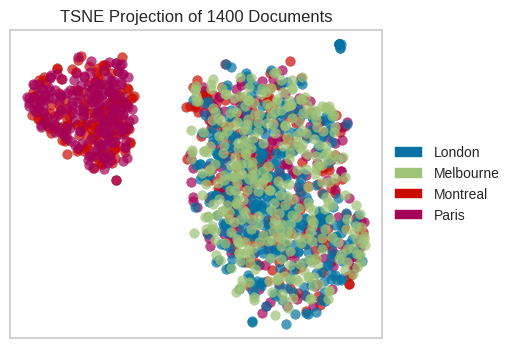

<Axes: title={'center': 'TSNE Projection of 1400 Documents'}>

In [ ]:
# vectorizer = CountVectorizer(analyzer='word', max_features=3000, lowercase=True, ngram_range=(1,1))
# vec_X_train = vectorizer.fit_transform(X_train)
# features = vectorizer.get_feature_names_out()

# # L2 Squared Euclidean Distance
# tsnse = TSNEVisualizer(size = (600, 400))
# tsnse.fit(vec_X_train, y_train)
# tsnse.poof()

Vectorizer without Stopwords

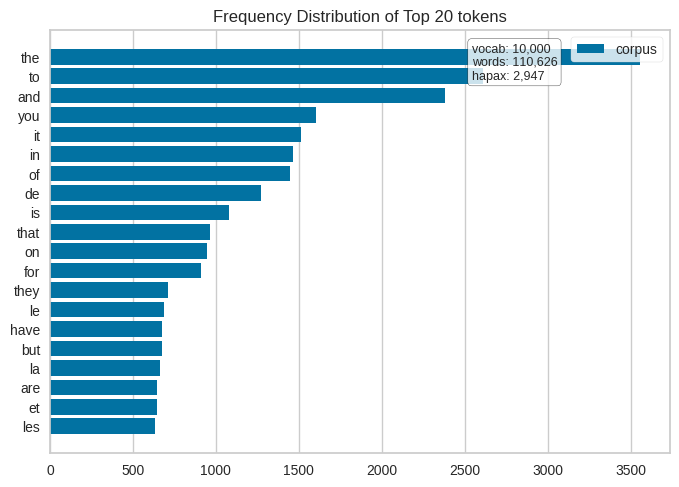

<Axes: title={'center': 'Frequency Distribution of Top 20 tokens'}>

In [ ]:
vectorizer = CountVectorizer(max_features=10000)
vec_X_train = vectorizer.fit_transform(X_train)
features = vectorizer.get_feature_names_out()

visualizer = FreqDistVisualizer(features=features, n=20)
visualizer.fit(vec_X_train)
visualizer.poof()

Vectorizer with Stopwords

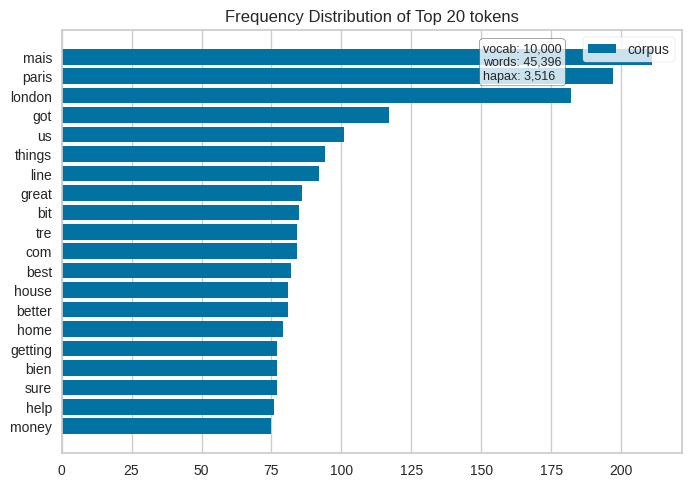

<Axes: title={'center': 'Frequency Distribution of Top 20 tokens'}>

In [ ]:
vectorizer = CountVectorizer(max_features=10000, stop_words=stopwords_list)
vec_X_train = vectorizer.fit_transform(X_train)
features = vectorizer.get_feature_names_out()

visualizer = FreqDistVisualizer(features=features, n=20)
visualizer.fit(vec_X_train)
visualizer.poof()

# Bernoulli Naive Bayes

Bernoulli Naive Bayes Model

In [ ]:
class BernoulliNaiveBayes:
  def __init__(self, alpha=0.1, prior = 'learn'):
    self.prior_prob = 0
    self.alpha = alpha
    self.prior = prior

  def fit(self, X, y):
    X=X.toarray() # convert X from sparse matrix to dense matrix
    # Compute each class probability
    class_counts = y.value_counts()
    num_labels = len(class_counts)
    if self.prior == 'learn': # learn the class probability from training data
      self.class_probabilities = class_counts / len(y)
    elif self.prior == 'uniform': # assume its probabilites are uniform
      self.class_probabilities = pd.Series(np.repeat(1/num_labels, num_labels), index = class_counts.index)

    # Sort the order of labels
    self.class_probabilities.sort_index(inplace = True)
    class_counts.sort_index(inplace = True)

    # train the model
    features_count = np.empty((num_labels, X.shape[1]))

    y_numpy = y.to_numpy()

    # get the summation counts on each features of samples with the same label
    for i in range(num_labels):
      label = self.class_probabilities.index[i]
      X_label_i = X[np.nonzero(y_numpy==label),:]
      # print(X_label_i.shape)
      # print(np.sum(X_label_i, axis=0).shape)
      # print(features_count[i,:].shape)
      features_count[i,:] = np.sum(X_label_i, axis=1) # axis = 1 because the shape of X_label_i is (1, #samples, #features)

    # Laplace Smoothing
    smoothed_numerator = features_count + self.alpha # get the summation counts on each features of samples with the same class
    smoothed_denominator = class_counts.values.reshape(-1,1) + 2 * self.alpha # get total number of samples for each class
    self.parameters = pd.DataFrame(smoothed_numerator /  smoothed_denominator, index = self.class_probabilities.index) # theta_{j,k}, j^th features, k^th class

  def predict(self, X):
    X = X.toarray()
    delta = pd.DataFrame(columns=self.class_probabilities.index)
    # computing the probability to be classified to each class given X
    for label in self.class_probabilities.index:
        # Get probability of currect class P(y=k)
        class_probability = self.class_probabilities[label]

        # Get theta_{j,k} for current class k
        theta_j_class = self.parameters.loc[label, :].to_numpy()

        # Compute P(x_j | y = k)
        prob_features_given_y = (theta_j_class ** X) * (1 - theta_j_class) ** (1 - X)
        # Compute P(x | y = k)
        prob_sample_given_y = np.prod(prob_features_given_y, axis=1)

        # Compute P(y) * P(x | y = k)
        term1 = np.log(class_probability)
        term2 = np.sum(X * np.log(theta_j_class), axis=1)
        term3 = np.sum((1 - X) * np.log(1 - theta_j_class), axis=1)
        delta_k = term1 + term2 + term3

        # Append
        delta[label] = delta_k

    predicted_class = delta.idxmax(axis=1)

    return predicted_class.to_list()

  def score(self, X, y):
    y_pred = self.predict(X)
    accuracy = np.count_nonzero(y == y_pred) / len(y_pred)
    return accuracy

  def get_params(self, deep=True):
    """Getter for parameters"""

    params = {"alpha": self.alpha,
              "prior": self.prior}
    return params

  def set_params(self, **parameters):
    "Setter for parameters"
    for parameter, value in parameters.items():
        setattr(self, parameter, value)
    return self

GridSearch Cross Validation for the Best Hyperparameters



In [ ]:
# pipe_params = {
#     "vect__stop_words": [None, list(text.ENGLISH_STOP_WORDS)],
#     "vect__max_features": [3000, 9000, 10000],
#     "vect__ngram_range": [(1,1), (1,2), (1,3)],
#     # "selecter__k":[3000, 7000, 'all'],
#     "classify__alpha" : [0.001, 0.01, 0.1, 1],
#     # "classify__prior" : ["learn", "uniform"],
# }

pipe_params = {
    "vect": [CountVectorizer(analyzer='word', lowercase=True), TfidfVectorizer(analyzer='word', lowercase=True)],
    "vect__binary": [True, False],
    "vect__stop_words": [None, stopwords_list],
    "vect__max_features": [3000, 6000, 10000],
    "vect__ngram_range": [(1,1),(1,2),(1,3)],
    "classify__alpha" : [0.001,0.01,0.1,1],
}


# vectorizer = CountVectorizer(lowercase=True)
# vectorizer = TfidfVectorizer(lowercase=True)
normalizer = Normalizer()
naive_bayes_model = BernoulliNaiveBayes()

pipe = Pipeline(
    steps=[("vect", CountVectorizer(analyzer='word', lowercase=True)), ("norm", normalizer), ("classify", BernoulliNaiveBayes())]
)

grid = model_selection.GridSearchCV(pipe, pipe_params, verbose=1, n_jobs=-1, cv=10)

grid.fit(X_train, y_train)

print(f"The best accuracy is {grid.best_score_}.")
print(f"The winning parameters are {grid.best_params_}")

# grid.score(X_train,y_train)

Fitting 10 folds for each of 288 candidates, totalling 2880 fits
The best accuracy is 0.68.
The winning parameters are {'classify__alpha': 0.01, 'vect': CountVectorizer(max_features=10000, ngram_range=(1, 3),
                stop_words=['sometime', '‘ve', 'get', 'don', 'rather',
                            'perhaps', 'same', 'and', 'most', "'m", 'name',
                            'beside', 'from', 'done', 'it', 'isn', 'anything',
                            'afterwards', 'two', 'everything', 'n’t', "hadn't",
                            'full', 'themselves', 'thence', 'nevertheless',
                            'out', 'into', 'whether', 'anywhere', ...]), 'vect__binary': False, 'vect__max_features': 10000, 'vect__ngram_range': (1, 3), 'vect__stop_words': ['sometime', '‘ve', 'get', 'don', 'rather', 'perhaps', 'same', 'and', 'most', "'m", 'name', 'beside', 'from', 'done', 'it', 'isn', 'anything', 'afterwards', 'two', 'everything', 'n’t', "hadn't", 'full', 'themselves', 'thence', 'neverth

Kaggle Test

In [ ]:
# vectorizer = CountVectorizer(max_features=3000, stop_words=list(text.ENGLISH_STOP_WORDS), ngram_range=(1,1))
# vec_X_train = vectorizer.fit_transform(X_train)
# vec_X_test = vectorizer.transform(X_test)

# vec_X_train = Normalizer().transform(vec_X_train)
# vec_X_test = Normalizer().transform(vec_X_test)

# # print(vectorizer.get_feature_names_out())
# # print(len(vectorizer.get_feature_names_out()))
# model = BernoulliNaiveBayes()
# model.fit(vec_X_train, y_train)
# prediction = model.score(vec_X_train, y_train)
# print(prediction)

# prediction = model.predict(vec_X_test)
# print(prediction)
# id_data = list(range(len(prediction)))
# output = pd.DataFrame({'id':id_data, 'subreddit':prediction})
# output.to_csv('/content/drive/MyDrive/Colab Notebooks/ECSE551 Machine Learning for Engineers/project2/test_prediction/test_prediction_BNB_20240313.csv',index=False)

# Support Vector Machine

GridSearch Cross Validation for the Best Hyperparameters

In [ ]:
pipe_params = {
    "vect": [CountVectorizer(analyzer='word', lowercase=True), TfidfVectorizer(analyzer='word', lowercase=True)],
    "vect__binary": [True, False],
    "vect__stop_words": [None, stopwords_list],
    "vect__max_features": [3000, 6000, 10000],
    "vect__ngram_range": [(1,1),(1,2),(1,3)],
    # "classify__C" : np.logspace(0, 2, 4)
    "classify__C" : [0.01, 0.1, 1, 10, 100],
}


normalizer = Normalizer()
svm_model = LinearSVC()

pipe = Pipeline(
    steps = [
        ("vect", CountVectorizer(analyzer='word', lowercase=True)),
        ("normalizer", Normalizer()),
        ("classify", svm_model),
         ]
)

grid = model_selection.GridSearchCV(pipe, pipe_params, verbose=1, n_jobs=-1, cv=10)

grid.fit(X_train, y_train)

print(f"The best accuracy is {grid.best_score_}.")
print(f"The winning parameters are {grid.best_params_}")

Fitting 10 folds for each of 360 candidates, totalling 3600 fits
The best accuracy is 0.7328571428571429.
The winning parameters are {'classify__C': 1, 'vect': TfidfVectorizer(max_features=10000,
                stop_words=['sometime', '‘ve', 'get', 'don', 'rather',
                            'perhaps', 'same', 'and', 'most', "'m", 'name',
                            'beside', 'from', 'done', 'it', 'isn', 'anything',
                            'afterwards', 'two', 'everything', 'n’t', "hadn't",
                            'full', 'themselves', 'thence', 'nevertheless',
                            'out', 'into', 'whether', 'anywhere', ...]), 'vect__binary': False, 'vect__max_features': 10000, 'vect__ngram_range': (1, 1), 'vect__stop_words': ['sometime', '‘ve', 'get', 'don', 'rather', 'perhaps', 'same', 'and', 'most', "'m", 'name', 'beside', 'from', 'done', 'it', 'isn', 'anything', 'afterwards', 'two', 'everything', 'n’t', "hadn't", 'full', 'themselves', 'thence', 'nevertheless', 'out'

Kaggle Test

In [ ]:
pipe_params = {
    "vectorizer__stop_words": [stopwords_list],
    "vectorizer__max_features": [10000],
    "vectorizer__ngram_range": [(1,1)],
    "classify__C" : [0.6]
}

vectorizer = TfidfVectorizer(analyzer='word', lowercase=True, binary=False)
normalizer = Normalizer()
svm_model = LinearSVC()

pipe = Pipeline(
    steps = [
        ("vectorizer", vectorizer),
        ("normalizer", Normalizer()),
        ("classify", svm_model),
    ]
)

grid = model_selection.GridSearchCV(pipe, pipe_params, verbose=1, n_jobs=-1, cv=10, refit=True)

grid.fit(X_train, y_train)

print(f"The best accuracy is {grid.best_score_}.")
print(f"The winning parameters are {grid.best_params_}")
y_test_LinearSVM = grid.predict(X_test)


id_data = list(range(len(y_test_LinearSVM)))
output = pd.DataFrame({'id':id_data, 'subreddit':y_test_LinearSVM})
output.to_csv('/content/drive/MyDrive/Colab Notebooks/ECSE551 Machine Learning for Engineers/project2/test_prediction/test_prediction_LinearSVC_20240319.csv',index=False)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
The best accuracy is 0.7342857142857142.
The winning parameters are {'classify__C': 0.6, 'vectorizer__max_features': 10000, 'vectorizer__ngram_range': (1, 1), 'vectorizer__stop_words': ['of', 'various', 'however', 'fifteen', '‘s', 'same', 'anywhere', 'namely', 'both', 'seemed', 'now', 'take', 'anyone', 'several', 'beyond', 'well', 'among', 'where', 'eight', 'above', 'hers', 'rather', 'back', '‘ll', 'he', 'if', 'regarding', 'although', 'weren', 'will', 'make', 'themselves', 'beside', 'any', 'wouldn', 'sometime', 'thus', 'a', 'during', 'too', 'or', 'hasn', 'whoever', 'these', 'over', 'whence', 'before', 'isn', 'sometimes', 'by', 'after', 'ever', 'nor', 'into', 'her', 'haven', 'wa', 'ca', 'an', 'at', 'whenever', 'could', 'until', 'very', 'whereafter', 'anyhow', "aren't", 'enough', 'unless', 'some', '’s', 'needn', 'no', 'others', 'yourselves', 'am', 'via', '‘re', 'be', "couldn't", 'do', 'became', 'whither', 'top', 'whereas', 'wha

In [ ]:
svm_model = LinearSVC(C=0.6)
vectorizer = TfidfVectorizer(analyzer='word', lowercase=True, binary=False, stop_words=stopwords_list, max_features=10000, ngram_range=(1,1))
x_vectorized = vectorizer.fit_transform(X_train)
cv_results = cross_validate(svm_model, x_vectorized, y_train, cv=10, return_train_score=True)
print("cross validated training accuracy: " + str(cv_results['train_score'].mean()))
print("cross validated validation accuracy: " + str(cv_results['test_score'].mean()))

cross validated training accuracy: 0.9992857142857143
cross validated validation accuracy: 0.7385714285714287


# Logistic Regression

In [ ]:
pipe_params = {
    "vect": [CountVectorizer(analyzer='word', lowercase=True), TfidfVectorizer(analyzer='word', lowercase=True)],
    "vect__binary": [True, False],
    "vect__stop_words": [stopwords_list],
    "vect__max_features": [3000, 6000, 10000],
    "vect__ngram_range": [(1,1),(1,2),(1,3)],
    # "classify__C" : np.logspace(0, 2, 4)
    "classify__C" : np.concatenate((np.linspace(0.1, 1, 10),(np.linspace(2, 10, 9))))
}

normalizer = Normalizer()
LR_model = LogisticRegression(max_iter=1000)

pipe = Pipeline(
    steps = [
        ("vect", CountVectorizer(analyzer='word', lowercase=True)),
        ("normalizer", Normalizer()),
        ("classify", LR_model),
         ]
)

grid = model_selection.GridSearchCV(pipe, pipe_params, verbose=1, n_jobs=-1, cv=10)

grid.fit(X_train, y_train)

print(f"The best accuracy is {grid.best_score_}.")
print(f"The winning parameters are {grid.best_params_}")

Fitting 10 folds for each of 684 candidates, totalling 6840 fits
The best accuracy is 0.7292857142857143.
The winning parameters are {'classify__C': 10.0, 'vect': TfidfVectorizer(max_features=10000, ngram_range=(1, 2),
                stop_words=['sometime', '‘ve', 'get', 'don', 'rather',
                            'perhaps', 'same', 'and', 'most', "'m", 'name',
                            'beside', 'from', 'done', 'it', 'isn', 'anything',
                            'afterwards', 'two', 'everything', 'n’t', "hadn't",
                            'full', 'themselves', 'thence', 'nevertheless',
                            'out', 'into', 'whether', 'anywhere', ...]), 'vect__binary': False, 'vect__max_features': 10000, 'vect__ngram_range': (1, 2), 'vect__stop_words': ['sometime', '‘ve', 'get', 'don', 'rather', 'perhaps', 'same', 'and', 'most', "'m", 'name', 'beside', 'from', 'done', 'it', 'isn', 'anything', 'afterwards', 'two', 'everything', 'n’t', "hadn't", 'full', 'themselves', 'thence'

Kaggle Competition

In [ ]:
pipe_params = {
    "vect__stop_words": [stopwords_list],
    "vect__max_features": [10000],
    "vect__ngram_range": [(1,2)],
    "classify__C" : [10]
}

vectorizer = TfidfVectorizer(analyzer='word', lowercase=True, binary=False)
normalizer = Normalizer()
LR_model = LogisticRegression(max_iter=1000)

pipe = Pipeline(
    steps = [
        ("vect", vectorizer),
        ("normalizer", Normalizer()),
        ("classify", LR_model),
    ]
)

grid = model_selection.GridSearchCV(pipe, pipe_params, verbose=1, n_jobs=-1, cv=10, refit=True)

grid.fit(X_train, y_train)

print(f"The best accuracy is {grid.best_score_}.")
print(f"The winning parameters are {grid.best_params_}")
y_test_LinearSVM = grid.predict(X_test)


id_data = list(range(len(y_test_LinearSVM)))
output = pd.DataFrame({'id':id_data, 'subreddit':y_test_LinearSVM})
output.to_csv('/content/drive/MyDrive/Colab Notebooks/ECSE551 Machine Learning for Engineers/project2/test_prediction/test_prediction_LogisticRegression_20240315.csv',index=False)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
The best accuracy is 0.7292857142857143.
The winning parameters are {'classify__C': 10, 'vect__max_features': 10000, 'vect__ngram_range': (1, 2), 'vect__stop_words': ['sometime', '‘ve', 'get', 'don', 'rather', 'perhaps', 'same', 'and', 'most', "'m", 'name', 'beside', 'from', 'done', 'it', 'isn', 'anything', 'afterwards', 'two', 'everything', 'n’t', "hadn't", 'full', 'themselves', 'thence', 'nevertheless', 'out', 'into', 'whether', 'anywhere', 'make', "'ve", 'above', 'we', 'wouldn', 'then', 'put', "couldn't", '‘re', 'would', 'do', 'sixty', 'a', 'serious', 'will', 'a', 'thus', '‘s', 'didn', 'one', "aren't", 'seems', '‘ll', 'he', '‘m', 'never', 'latter', 'hereafter', 'also', 'how', 'using', 'ha', 'my', 'although', 'whereby', 'without', 'that', 'amount', 'myself', 'm', 'hereupon', 'toward', 'twelve', 'u', 'you', 'having', 'four', "it's", 'on', "won't", 'nothing', 'won', 'beforehand', 'alone', 'moreover', 'are', 'no', 'give', 'doi

C=2 LogisticRegression

In [ ]:
from sklearn.linear_model import LogisticRegression

pipe_params = {
    "vect__stop_words": [stopwords_list],
    "vect__max_features": [3000],
    "vect__ngram_range": [(1,1)],
    "classify__C" : [2]
}

vectorizer = TfidfVectorizer(analyzer='word', binary=False, tokenizer=New_LemmaTokenizer())
normalizer = Normalizer()
LR_model = LogisticRegression(penalty='l2', solver='liblinear', max_iter=1000)

pipe = Pipeline(
    steps = [
        ("vect", vectorizer),
        ("normalizer", Normalizer()),
        ("classify", LR_model),
    ]
)

grid = model_selection.GridSearchCV(pipe, pipe_params, verbose=1, n_jobs=1, cv=10, refit=True)

grid.fit(X_train, y_train)

print(f"The best accuracy is {grid.best_score_}.")
print(f"The winning parameters are {grid.best_params_}")
# y_test_LinearSVM = grid.predict(X_test)


# id_data = list(range(len(y_test_LinearSVM)))
# output = pd.DataFrame({'id':id_data, 'subreddit':y_test_LinearSVM})
# output.to_csv('/content/drive/MyDrive/Colab Notebooks/ECSE551 Machine Learning for Engineers/project2/test_prediction/test_prediction_LogisticRegression_20240315.csv',index=False)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['avon', 'ba', 'diver', 'e', 'far', 'fuss', 'gen', 'regard', 'serum'] not in stop_words.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['avon', 'ba', 'diver', 'e', 'far', 'fuss', 'gen', 'regard', 'serum'] not in stop_words.
  warnings.warn(
/usr/local/lib/pyt

The best accuracy is 0.6900000000000001.
The winning parameters are {'classify__C': 2, 'vect__max_features': 3000, 'vect__ngram_range': (1, 1), 'vect__stop_words': ['make', 'i', 'le', 'whereby', 'latter', 'd', "'re", "weren't", 'ten', 'well', 'yours', 'among', 'see', "n't", 'various', 'my', 'while', 'she', 'hadn', 'whole', 'yourselves', 'beyond', "isn't", "you'll", 'full', 'them', 'whenever', 'a', 'please', 'mightn', 'wasn', 'many', 'their', 'though', 'hence', "'m", 'are', 'been', 'side', 'shan', 'more', 'against', 'out', 'unless', 'sometime', 'n‘t', 'using', 'of', 'into', 'nor', "'ve", 'everything', 'upon', "don't", "she's", 'formerly', 'through', 'ourselves', 'fifty', 'can', '‘s', 'always', 'becoming', 'if', '’m', 'own', "needn't", 'hundred', 'don', "'s", 'having', 'every', 'thereafter', 'up', 'were', 'moreover', 'ain', 'an', "shan't", 'except', 'ever', 'part', 'three', 'how', 'about', 'two', 'last', 'thereupon', 'so', 'sometimes', 'have', "you'd", 'wherein', 'one', 'none', 'myself',

# Random Forest
Bagging of Decision Trees (Ensemble)

In [ ]:
pipe_params = {
    "vect": [CountVectorizer(analyzer='word', lowercase=True), TfidfVectorizer(analyzer='word', lowercase=True)],
    "vect__binary": [True, False],
    "vect__stop_words": [stopwords_list],
    "vect__max_features": [3000, 6000, 10000],
    "vect__ngram_range": [(1,1),(1,2),(1,3)],
    "classify__max_depth" : [None,0,10,20,30,40,50,60,70,80,90,100]
}

normalizer = Normalizer()
RandomForest_model = RandomForestClassifier(n_estimators=100, random_state=0)

pipe = Pipeline(
    steps = [
        ("vect", CountVectorizer(analyzer='word', lowercase=True)),
        ("normalizer", Normalizer()),
        ("classify", RandomForest_model),
         ]
)

grid = model_selection.GridSearchCV(pipe, pipe_params, verbose=1, n_jobs=-1, cv=10)

grid.fit(X_train, y_train)

print(f"The best accuracy is {grid.best_score_}.")
print(f"The winning parameters are {grid.best_params_}")

Fitting 10 folds for each of 432 candidates, totalling 4320 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
360 fits failed out of a total of 4320.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
360 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py", line 340, in fit
    self._validate_params()
  File "/usr/local/lib/python3.10/dist-pa

The best accuracy is 0.6814285714285715.
The winning parameters are {'classify__max_depth': 50, 'vect': CountVectorizer(binary=True, max_features=10000, ngram_range=(1, 2),
                stop_words=['sometime', '‘ve', 'get', 'don', 'rather',
                            'perhaps', 'same', 'and', 'most', "'m", 'name',
                            'beside', 'from', 'done', 'it', 'isn', 'anything',
                            'afterwards', 'two', 'everything', 'n’t', "hadn't",
                            'full', 'themselves', 'thence', 'nevertheless',
                            'out', 'into', 'whether', 'anywhere', ...]), 'vect__binary': True, 'vect__max_features': 10000, 'vect__ngram_range': (1, 2), 'vect__stop_words': ['sometime', '‘ve', 'get', 'don', 'rather', 'perhaps', 'same', 'and', 'most', "'m", 'name', 'beside', 'from', 'done', 'it', 'isn', 'anything', 'afterwards', 'two', 'everything', 'n’t', "hadn't", 'full', 'themselves', 'thence', 'nevertheless', 'out', 'into', 'whether', 'an

# KNN

In [ ]:
pipe_params = {
    "vect": [CountVectorizer(analyzer='word', lowercase=True), TfidfVectorizer(analyzer='word', lowercase=True)],
    "vect__binary": [True, False],
    "vect__stop_words": [stopwords_list],
    "vect__max_features": [3000, 6000, 10000],
    "vect__ngram_range": [(1,1),(1,2),(1,3)],
    "classify__n_neighbors" : np.arange(10,150,10)
}

normalizer = Normalizer()
KNN_model = KNeighborsClassifier()

pipe = Pipeline(
    steps = [
        ("vect", CountVectorizer(analyzer='word', lowercase=True)),
        ("normalizer", Normalizer()),
        ("classify", KNN_model),
         ]
)

grid = model_selection.GridSearchCV(pipe, pipe_params, verbose=1, n_jobs=-1, cv=10)

grid.fit(X_train, y_train)

print(f"The best accuracy is {grid.best_score_}.")
print(f"The winning parameters are {grid.best_params_}")

Fitting 10 folds for each of 504 candidates, totalling 5040 fits
The best accuracy is 0.6478571428571429.
The winning parameters are {'classify__n_neighbors': 20, 'vect': TfidfVectorizer(max_features=10000, ngram_range=(1, 3),
                stop_words=['sometime', '‘ve', 'get', 'don', 'rather',
                            'perhaps', 'same', 'and', 'most', "'m", 'name',
                            'beside', 'from', 'done', 'it', 'isn', 'anything',
                            'afterwards', 'two', 'everything', 'n’t', "hadn't",
                            'full', 'themselves', 'thence', 'nevertheless',
                            'out', 'into', 'whether', 'anywhere', ...]), 'vect__binary': False, 'vect__max_features': 10000, 'vect__ngram_range': (1, 3), 'vect__stop_words': ['sometime', '‘ve', 'get', 'don', 'rather', 'perhaps', 'same', 'and', 'most', "'m", 'name', 'beside', 'from', 'done', 'it', 'isn', 'anything', 'afterwards', 'two', 'everything', 'n’t', "hadn't", 'full', 'themselves', 

# Ensemble Stacking

In [ ]:
# emsemble
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import StackingClassifier
vectorizer = TfidfVectorizer(analyzer='word', lowercase=True, binary=False, max_features=10000, ngram_range=(1,1),stop_words=stopwords_list)
vec_X_train = np.asarray(vectorizer.fit_transform(X_train).todense())
vec_X_test = np.asarray(vectorizer.transform(X_test).todense())
encoded_y_train
clf1 = LogisticRegression(max_iter=1000, C=10)
clf2 = LinearSVC(C = 1)
clf3 = RandomForestClassifier(n_estimators=100, random_state=0, max_depth=50)

eclf1 = StackingClassifier(estimators=[
        ('svm', clf2), ('lr', clf1), ('rf', clf3)])

start = time.time()
cv_results = cross_validate(eclf1, vec_X_train, encoded_y_train, cv=10, return_train_score=True)
end = time.time()

print("cross validated training accuracy: " + str(cv_results['train_score'].mean()))
print("cross validated validation accuracy: " + str(cv_results['test_score'].mean()))

cross validated training accuracy: 0.9992857142857143
cross validated validation accuracy: 0.7407142857142858


Kaggle Test

In [ ]:
eclf1.fit(vec_X_train,encoded_y_train)

y_test_Ensemble_Stacking = eclf1.predict(vec_X_test)

id_data = list(range(len(y_test_Ensemble_Stacking)))
output = pd.DataFrame({'id':id_data, 'subreddit':y_test_Ensemble_Stacking})
output.to_csv('/content/drive/MyDrive/Colab Notebooks/ECSE551 Machine Learning for Engineers/project2/test_prediction/test_prediction_Ensemble_Stacking_20240319.csv',index=False)

In [ ]:
test_prediction_Ensemble_Stacking_20240319 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ECSE551 Machine Learning for Engineers/project2/test_prediction/test_prediction_Ensemble_Stacking_20240319.csv')


,id,subreddit
0,0,0
1,1,0
2,2,0
3,3,1
4,4,2
...,...,...
595,595,3
596,596,0
597,597,3
598,598,0


In [ ]:
label_name_list

['Melbourne', 'Paris', 'London', 'Montreal']

In [ ]:
test_prediction_Ensemble_Stacking_20240319.to_csv('/content/drive/MyDrive/Colab Notebooks/ECSE551 Machine Learning for Engineers/project2/test_prediction/test_prediction_Ensemble_Stacking_20240319.csv',index=False)